In [10]:
from utils.paths import *
%matplotlib inline

In [11]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.io import loadmat
import numpy as np
import h5py
import pandas
import scipy
from scipy.ndimage.interpolation import zoom
from skimage import measure
import SimpleITK as sitk
from scipy.ndimage.morphology import binary_dilation,generate_binary_structure
from skimage.morphology import convex_hull_image
import pandas
from multiprocessing import Pool
from functools import partial
import sys
from joblib import Parallel, delayed
import warnings

In [12]:
def load_train(PATH):
    src = PATH['src']
    data_path = src
    folders = [x for x in os.listdir(data_path) if 'subset' in x]
    os.chdir(data_path)
    patients = []
    for i in folders:
        os.chdir(data_path + i)
        # print('Changing folder to: {}'.format(data_path + i))
        patient_ids = [x for x in os.listdir(data_path + i) if '.mhd' in x]
        for id in patient_ids:
            j = '{}/{}'.format(i, id)
            patients.append(j)
    return patients

def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return (f)

def resample(imgs, spacing, new_spacing,order=2):
    if len(imgs.shape)==3:
        new_shape = np.round(imgs.shape * spacing / new_spacing)
        true_spacing = spacing * imgs.shape / new_shape
        resize_factor = new_shape / imgs.shape
        imgs = zoom(imgs, resize_factor, mode = 'nearest',order=order)
        return imgs, true_spacing
    elif len(imgs.shape)==4:
        n = imgs.shape[-1]
        newimg = []
        for i in range(n):
            slice = imgs[:,:,:,i]
            newslice,true_spacing = resample(slice,spacing,new_spacing)
            newimg.append(newslice)
        newimg=np.transpose(np.array(newimg),[1,2,3,0])
        return newimg,true_spacing
    else:
        raise ValueError('wrong shape')
def worldToVoxelCoord(worldCoord, origin, spacing):
     
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def load_itk_image(filename):
    with open(filename) as f:
        contents = f.readlines()
        line = [k for k in contents if k.startswith('TransformMatrix')][0]
        transformM = np.array(line.split(' = ')[1].split(' ')).astype('float')
        transformM = np.round(transformM)
        if np.any( transformM!=np.array([1,0,0, 0, 1, 0, 0, 0, 1])):
            isflip = True
        else:
            isflip = False

    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing,isflip

def process_mask(mask):
    convex_mask = np.copy(mask)
    for i_layer in range(convex_mask.shape[0]):
        mask1  = np.ascontiguousarray(mask[i_layer])
        if np.sum(mask1)>0:
            mask2 = convex_hull_image(mask1)
            if np.sum(mask2)>1.5*np.sum(mask1):
                mask2 = mask1
        else:
            mask2 = mask1
        convex_mask[i_layer] = mask2
    struct = generate_binary_structure(3,1)  
    dilatedMask = binary_dilation(convex_mask,structure=struct,iterations=10) 
    return dilatedMask


def lumTrans(img):
    lungwin = np.array([-1200.,600.])
    newimg = (img-lungwin[0])/(lungwin[1]-lungwin[0])
    newimg[newimg<0]=0
    newimg[newimg>1]=1
    newimg = (newimg*255).astype('uint8')
    return newimg


In [13]:
def save_npy(patient,df_node,islabel):
    patient_id = patient.split('/')[-1][:-4]
    mini_df = df_node[df_node["file"] == patient]
    if mini_df.shape[0] > 0:

        islabel = True
        isClean = True
        resolution = np.array([1, 1, 1])
        #     resolution = np.array([2,2,2])
        name = patient_id

        Mask, origin, spacing, isflip = load_itk_image(PATH['src'] + patient)
        sliceim = Mask.copy()
        if isflip:
            Mask = Mask[:, ::-1, ::-1]
        newshape = np.round(np.array(Mask.shape) * spacing / resolution).astype('int')
        m1 = Mask == 3
        m2 = Mask == 4
        Mask = m1 + m2 
        
        xx, yy, zz = np.where(Mask)
        box = np.array([[np.min(xx), np.max(xx)], [np.min(yy), np.max(yy)], [np.min(zz), np.max(zz)]])
        box = box * np.expand_dims(spacing, 1) / np.expand_dims(resolution, 1)
        box = np.floor(box).astype('int')
        margin = 5
        extendbox = np.vstack(
            [np.max([[0, 0, 0], box[:, 0] - margin], 0), np.min([newshape, box[:, 1] + 2 * margin], axis=0).T]).T

        #this_annos = np.copy(annos[annos[:, 0] == int(name)])
        if isClean:
            convex_mask = m1
            dm1 = process_mask(m1)
            dm2 = process_mask(m2)
            dilatedMask = dm1 + dm2
            Mask = m1 + m2
            extramask = dilatedMask ^ Mask
            bone_thresh = 210
            pad_value = 170
            sliceim = lumTrans(sliceim)
            sliceim = sliceim * dilatedMask + pad_value * (1 - dilatedMask).astype('uint8')
            bones = (sliceim * extramask) > bone_thresh
            sliceim[bones] = pad_value

            sliceim1, _ = resample(sliceim, spacing, resolution, order=1)
            sliceim2 = sliceim1[extendbox[0, 0]:extendbox[0, 1],
                       extendbox[1, 0]:extendbox[1, 1],
                       extendbox[2, 0]:extendbox[2, 1]]
            sliceim = sliceim2[np.newaxis, ...]
            np.save(os.path.join(savepath, name + '_clean.npy'), sliceim)

        if islabel:

            this_annos = np.copy(df_node[df_node["seriesuid"] == patient_id])
            label = []
            if len(this_annos) > 0:
                for c in this_annos:
                    pos = worldToVoxelCoord(c[1:4][::-1], origin=origin, spacing=spacing)
                    if isflip:
                        pos[1:] = Mask.shape[1:3] - pos[1:]
                    label.append(np.concatenate([pos, [c[4] / spacing[1]]]))
            label = np.array(label)
            if len(label) == 0:
                label2 = np.array([[0, 0, 0, 0]])
            else:
                label2 = np.copy(label).T
                label2[:3] = label2[:3] * np.expand_dims(spacing, 1) / np.expand_dims(resolution, 1)
                label2[3] = label2[3] * spacing[1] / resolution[1]
                label2[:3] = label2[:3] - np.expand_dims(extendbox[:, 0], 1)
                label2 = label2[:4].T
            np.save(os.path.join(savepath, name + '_label.npy'), label2)           
            
        

In [ ]:
PATH = {'annotations_path' : annotations_train_path,
        'src' : src_train,
        'dst_full_lungs' : full_lung_train}  

In [ ]:
savepath = PATH['dst_full_lungs']
patients = load_train(PATH)
df_node = pd.read_csv(PATH['annotations_path']+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(patients, file_name)) 

In [6]:
Parallel(n_jobs=-1)(delayed(save_npy)(patient,df_node,islabel=True) for patient in tqdm(sorted(patients)))

100%|██████████| 600/600 [1:20:07<00:00,  7.19s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [14]:
PATH = {'annotations_path' : annotations_val_path,
        'src' : src_val,
        'dst_full_lungs' : full_lung_val}  

In [15]:
savepath = PATH['dst_full_lungs']
patients = load_train(PATH)
df_node = pd.read_csv(PATH['annotations_path']+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(patients, file_name)) 

In [16]:
Parallel(n_jobs=-1)(delayed(save_npy)(patient,df_node,islabel=True) for patient in tqdm(sorted(patients)))


 40%|████      | 81/200 [09:44<17:42,  8.93s/it]/Users/mahui/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)

100%|██████████| 200/200 [28:11<00:00, 12.84s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
PATH = {'annotations_path' : annotations_test_path,
        'src' : src_test,
        'dst_full_lungs' : full_lung_test} 

In [18]:
savepath = PATH['dst_full_lungs']
patients = load_train(PATH)
df_node = pd.read_csv(PATH['annotations_path']+"annotations.csv")
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(patients, file_name)) 

In [19]:
Parallel(n_jobs=-1)(delayed(save_npy)(patient,df_node,islabel=False) for patient in tqdm(sorted(patients)))


 26%|██▌       | 52/200 [07:10<16:27,  6.67s/it]/Users/mahui/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)

100%|██████████| 200/200 [28:29<00:00,  7.01s/it]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [30]:
img_array = np.load('/Volumes/solo/ali/Data/test_mask/val_full_lung/LKDS-00012_clean.npy')
img_array = np.squeeze(img_array)

IOError: [Errno 2] No such file or directory: '/Volumes/solo/ali/Data/test_mask/val_full_lung/LKDS-00012_clean.npy'

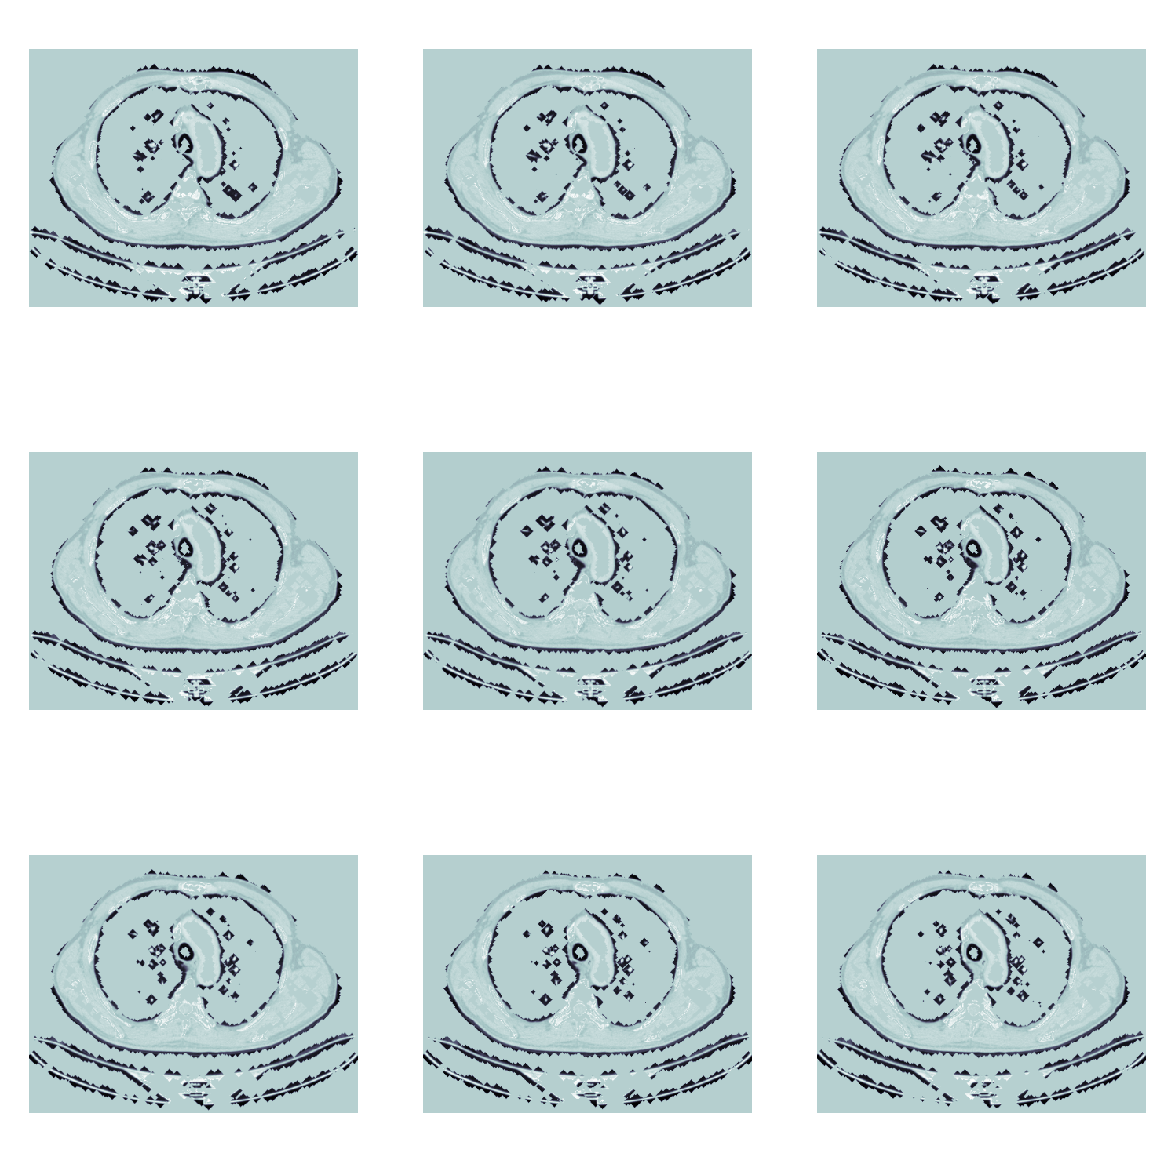

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
f, plots = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(20, 21))
# matplotlib is drunk

for i in range(9):
    plots[i // 3, i % 3].axis('off')
    plots[i // 3, i % 3].imshow(img_array[100+i], cmap=plt.cm.bone)

In [33]:
cc = np.load('/Volumes/solo/ali/Data/test_mask/test_full_lung/LKDS-00012_label.npy')
cc

array([[11.5, 174.87769124099995, 175.69398815160002, 10.39424385],
       [16.76610169, 201.92219115799998, 127.92719909540001, 10.40601537],
       [41.00000000000001, 197.500154476, 120.00007550740003,
        6.592207651000001],
       [150.0, 114.05670577099997, 112.56610852969999, 7.969218795],
       [258.7751061, 196.23636297999997, 327.704590901, 11.05283272],
       [259.8804124, 98.98462858699997, 306.7836982369, 12.28167792]], dtype=object)

In [2]:
import torch

In [3]:
torch.cuda.is_available()

False